# Model report 

In [2]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import keras
from keras.models import load_model
import keras.backend as K

from sincnet import SincConv1D

from train_normal import DataGenerator, print_cm
import sklearn.metrics
import shap
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

Using TensorFlow backend.
         when using: `python -m better_exceptions'. Otherwise, only code
         loaded from files will be inspected!
         when using: `python -m better_exceptions'. Otherwise, only code
         loaded from files will be inspected!


In [3]:
def load_data():
    g = DataGenerator()
    X, y = g.data()
    train_set, valid_set, test_set = g.split(X, y)
    
    # do normalize using means and stds from training data
    train_set[0], means_and_stds = DataGenerator.normalize(train_set[0])
    valid_set[0], _ = DataGenerator.normalize(valid_set[0], means_and_stds)
    test_set[0], _ = DataGenerator.normalize(test_set[0], means_and_stds)
    
    return train_set, valid_set, test_set

WHOLE_DATASET = load_data()

baseline: 0.8921465968586387


In [4]:
MODEL_CACHE = None
MODEL_CACHE_NAME = None

In [5]:
import numpy as np
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [28]:
def get_report(model_path, set_name='test'):
    def print_basic_report(y_true, y_pred):
        print('\n=============================== {} ===============================\n'.format('Basic report'))
        print('Total accuracy:', sklearn.metrics.accuracy_score(y_true, y_pred))
        print(sklearn.metrics.classification_report(y_true, y_pred))
        print_cm(sklearn.metrics.confusion_matrix(y_true, y_pred), ['normal', 'patient'])
        
    def plot(signal, original=None, do_filter=True):
        n_channel = signal.shape[-1]
        fig, axes = plt.subplots(n_channel, 1, figsize=(30, 2*n_channel), sharex=True)
        fig.tight_layout()
        
        signal_min, signal_max = np.Inf, -np.Inf
        for i_channel, ax in enumerate(axes):
            if i_channel >= 8:
                s = butter_lowpass_filter(signal[..., i_channel], 8, 1000, order=10) if do_filter else signal[..., i_channel]
            else:
                s = np.convolve(signal[..., i_channel], np.ones((50,))/50., mode='same') if do_filter else signal[..., i_channel]
                signal_min, signal_max = min(signal_min, s.min()), max(signal_max, s.max())
            
            ax.plot(s, color='g')
            ax.plot(np.zeros_like(signal[..., i_channel]), color='r')
            if original is not None:
                ax.twinx().plot(original[..., i_channel], alpha=0.3, color='b')
        
        for ax in axes[:8]: ax.set_ylim(signal_min, signal_max)
        plt.margins(x=0, y=0)
        plt.show()
        
    def plot_explain(model, sample_index, sample_X, is_positive, title):
        def map2layer(x, layer):
            feed_dict = dict(zip([model.layers[0].input], [x.copy()]))
            return K.get_session().run(model.layers[layer].input, feed_dict)
        
        sample_X = sample_X[np.newaxis, ...]
        
        print('\n=============================== {} ===============================\n'.format(title))
        print('From Set:', set_name, 'set')
        print('Sample id:', sample_index)
        print('Sample is', 'abnormal' if is_positive == 1 else 'normal')
        print('Predict abnormal chance:', model.predict(sample_X)[0][1])
        
        # e = shap.DeepExplainer(model, WHOLE_DATASET[0][0])
        # shap_values = e.shap_values(sample_X)
        # plot(shap_values[0][0, ...], sample_X[0, :, :])
        
        layer_to_explain = 0
        
        e = shap.GradientExplainer(
            (model.layers[layer_to_explain].input, model.layers[-1].output),
            map2layer(WHOLE_DATASET[0][0], layer_to_explain),
            local_smoothing=0 # std dev of smoothing noise
        )
        shap_values,indexes = e.shap_values(map2layer(sample_X, layer_to_explain), ranked_outputs=2)
        plot(shap_values[int(indexes[0][0])][0, ...], sample_X[0, :, :])
        
    
    # get data instance
    dataset_X, dataset_y = WHOLE_DATASET[{'train':0, 'valid':1, 'test':2}[set_name]]
    
    # get one sample
    # sample_index = np.random.choice( np.where(dataset_y[:, 1] == positive)[0], size=1)
    # sample_X, sample_y = dataset_X[sample_index], dataset_y[sample_index]
    # sample_X, sample_y = sample_X[np.newaxis, ...], sample_y[np.newaxis, ...]
    
    # load model
    # do cache thing
    print('Loading model', model_path)
    
    global MODEL_CACHE
    global MODEL_CACHE_NAME
    if MODEL_CACHE_NAME == model_path:
        print('Using model cache!')
        model = MODEL_CACHE
    else:
        K.clear_session()
        model = load_model(model_path, custom_objects={'SincConv1D': SincConv1D}, compile=False)
        # update cache
        MODEL_CACHE = model
        MODEL_CACHE_NAME = model_path
        
    model.summary()
    
    y_pred = np.argmax(model.predict(dataset_X, batch_size=dataset_X.shape[0]), axis=1)
    y_true = dataset_y[:, 1]
    
    # start analysis
    print('Report for', model_path)
    
    # get basic report
    print_basic_report(y_true, y_pred)
    
    # shap visualization
    
    # plot succeed positive case
    sample_index = np.random.choice(np.where(np.logical_and(y_true == 1, y_pred == y_true))[0], size=1)[0]
    plot_explain(model, sample_index, dataset_X[sample_index], dataset_y[sample_index, 1], 'SUCCEED POSITIVE CASE')
    
    # plot succeed negative case
    sample_index = np.random.choice(np.where(np.logical_and(y_true == 0, y_pred == y_true))[0], size=1)[0]
    plot_explain(model, sample_index, dataset_X[sample_index], dataset_y[sample_index, 1], 'SUCCEED NEGATIVE CASE')
    
    # plot failed positive case
    sample_index = np.random.choice(np.where(np.logical_and(y_true == 1, y_pred != y_true))[0], size=1)[0]
    plot_explain(model, sample_index, dataset_X[sample_index], dataset_y[sample_index, 1], 'FAILED POSITIVE CASE')
    
    # plot failed negative case
    sample_index = np.random.choice(np.where(np.logical_and(y_true == 0, y_pred != y_true))[0], size=1)[0]
    plot_explain(model, sample_index, dataset_X[sample_index], dataset_y[sample_index, 1], 'FAILED NEGATIVE CASE')

Loading model ./model_checkpoints/workingV2_200_0.12/200-0.12.h5
Using model cache!
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10000, 10)    0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 10000, 2)     0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 10000, 1)     0           lambda_2[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 10000, 1)     0           lambda_2[0][0]                   
_________________________

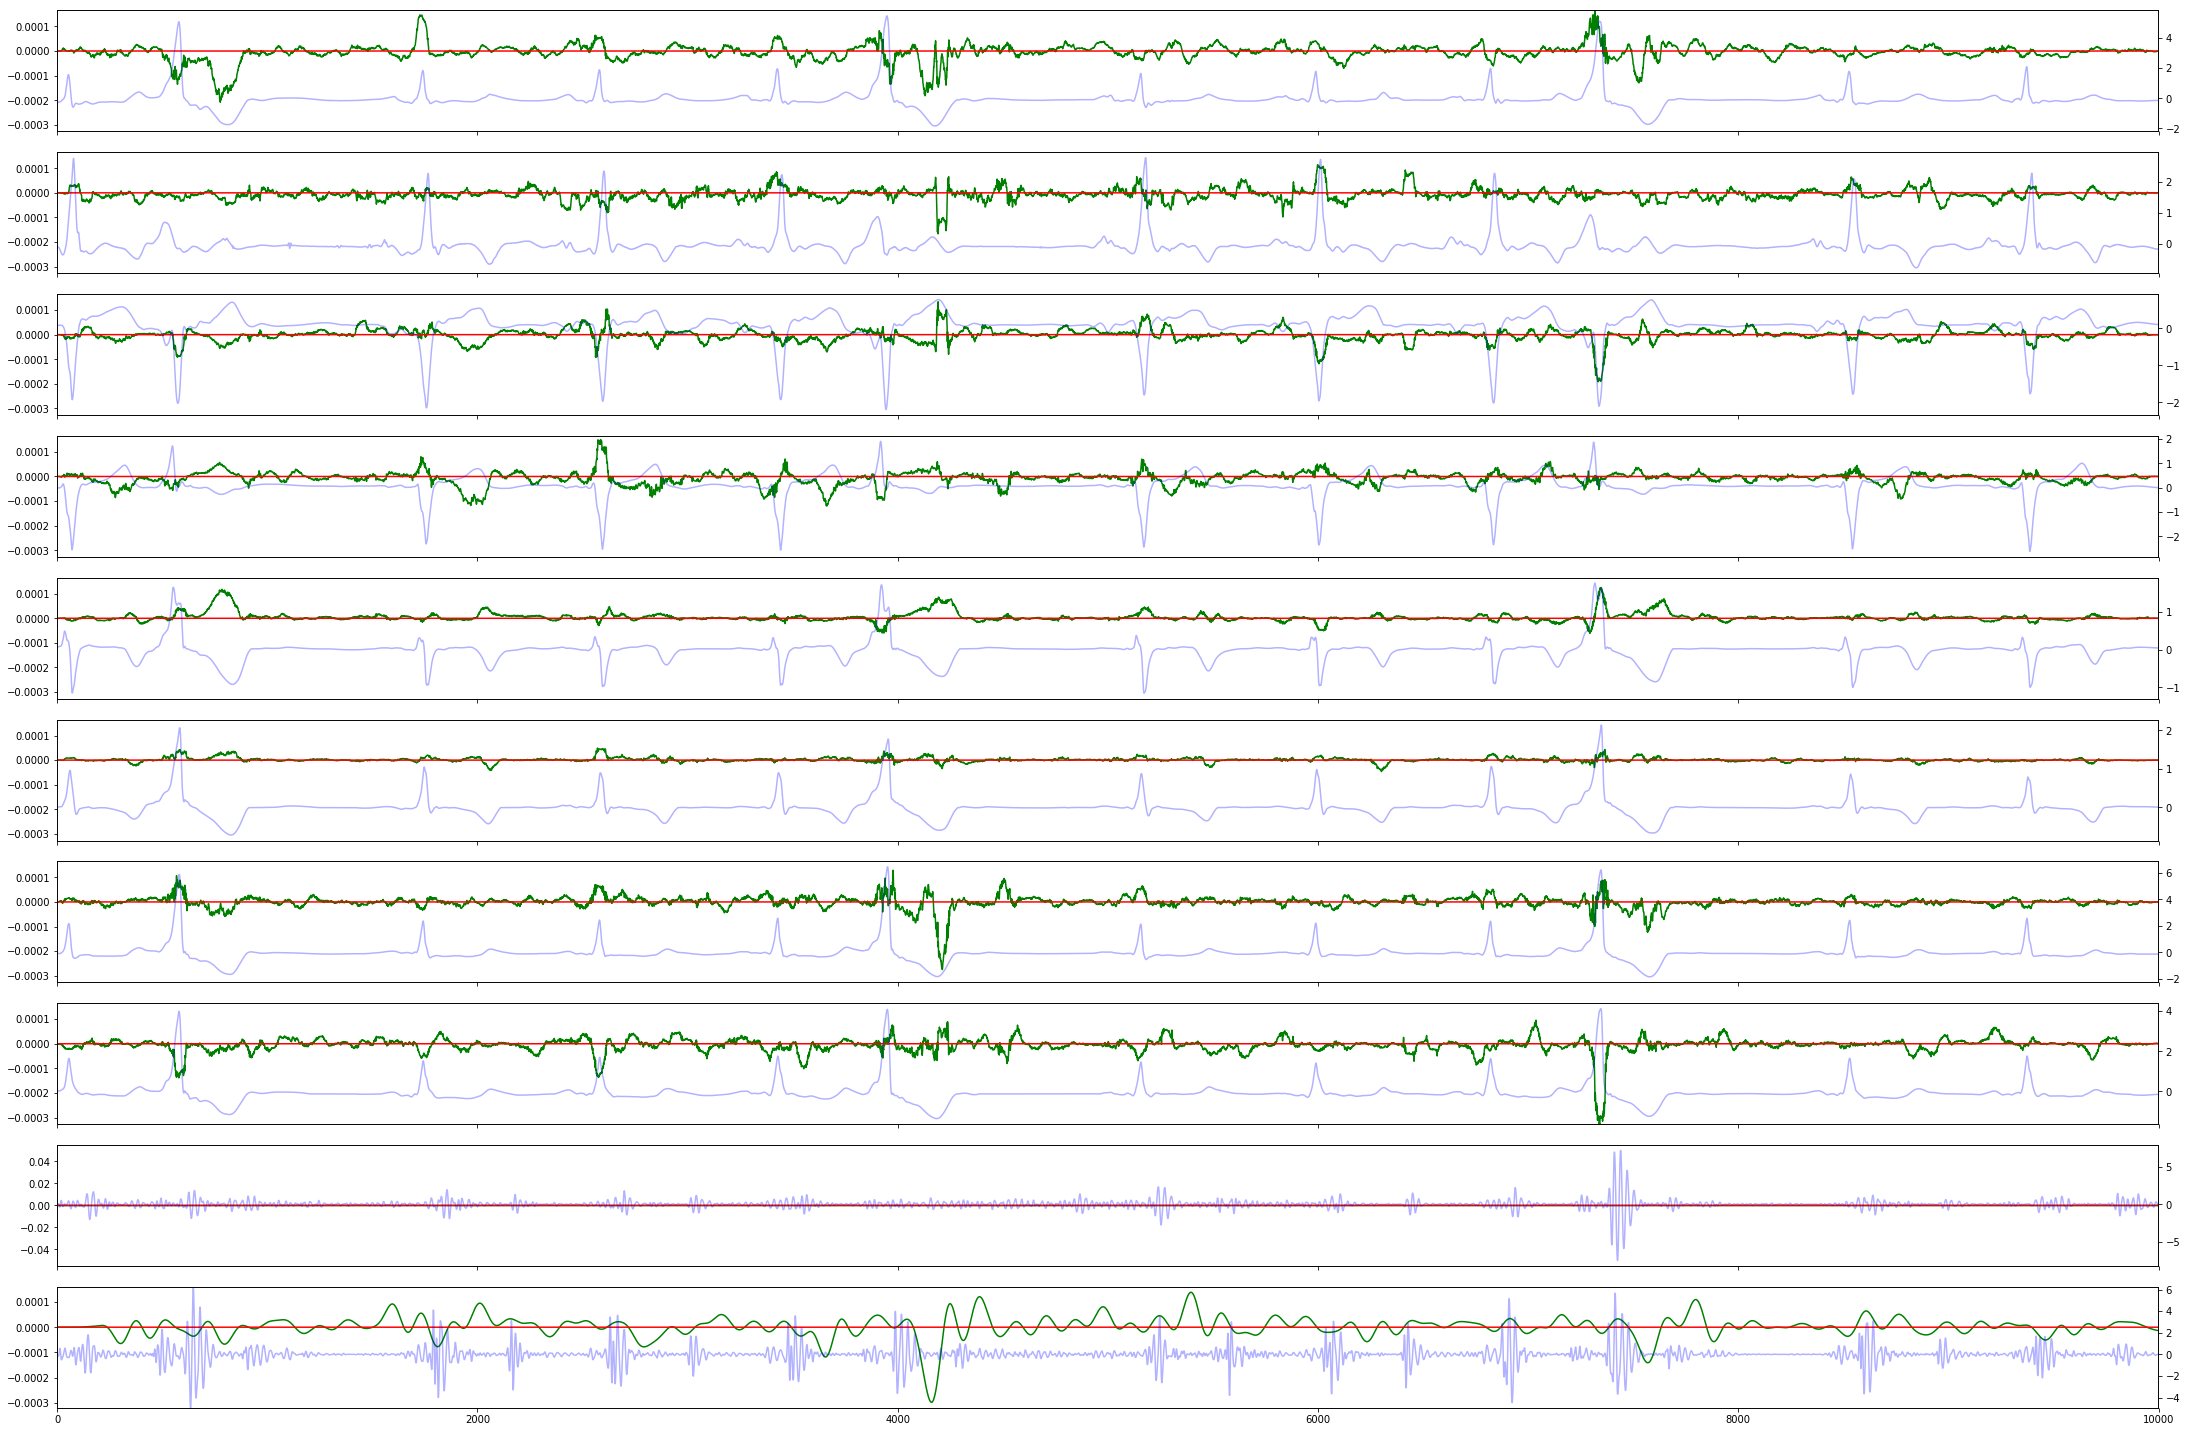


=============================== SUCCEED NEGATIVE CASE ===============================

From Set: test set
Sample id: 0
Sample is normal
Predict abnormal chance: 0.00023622994


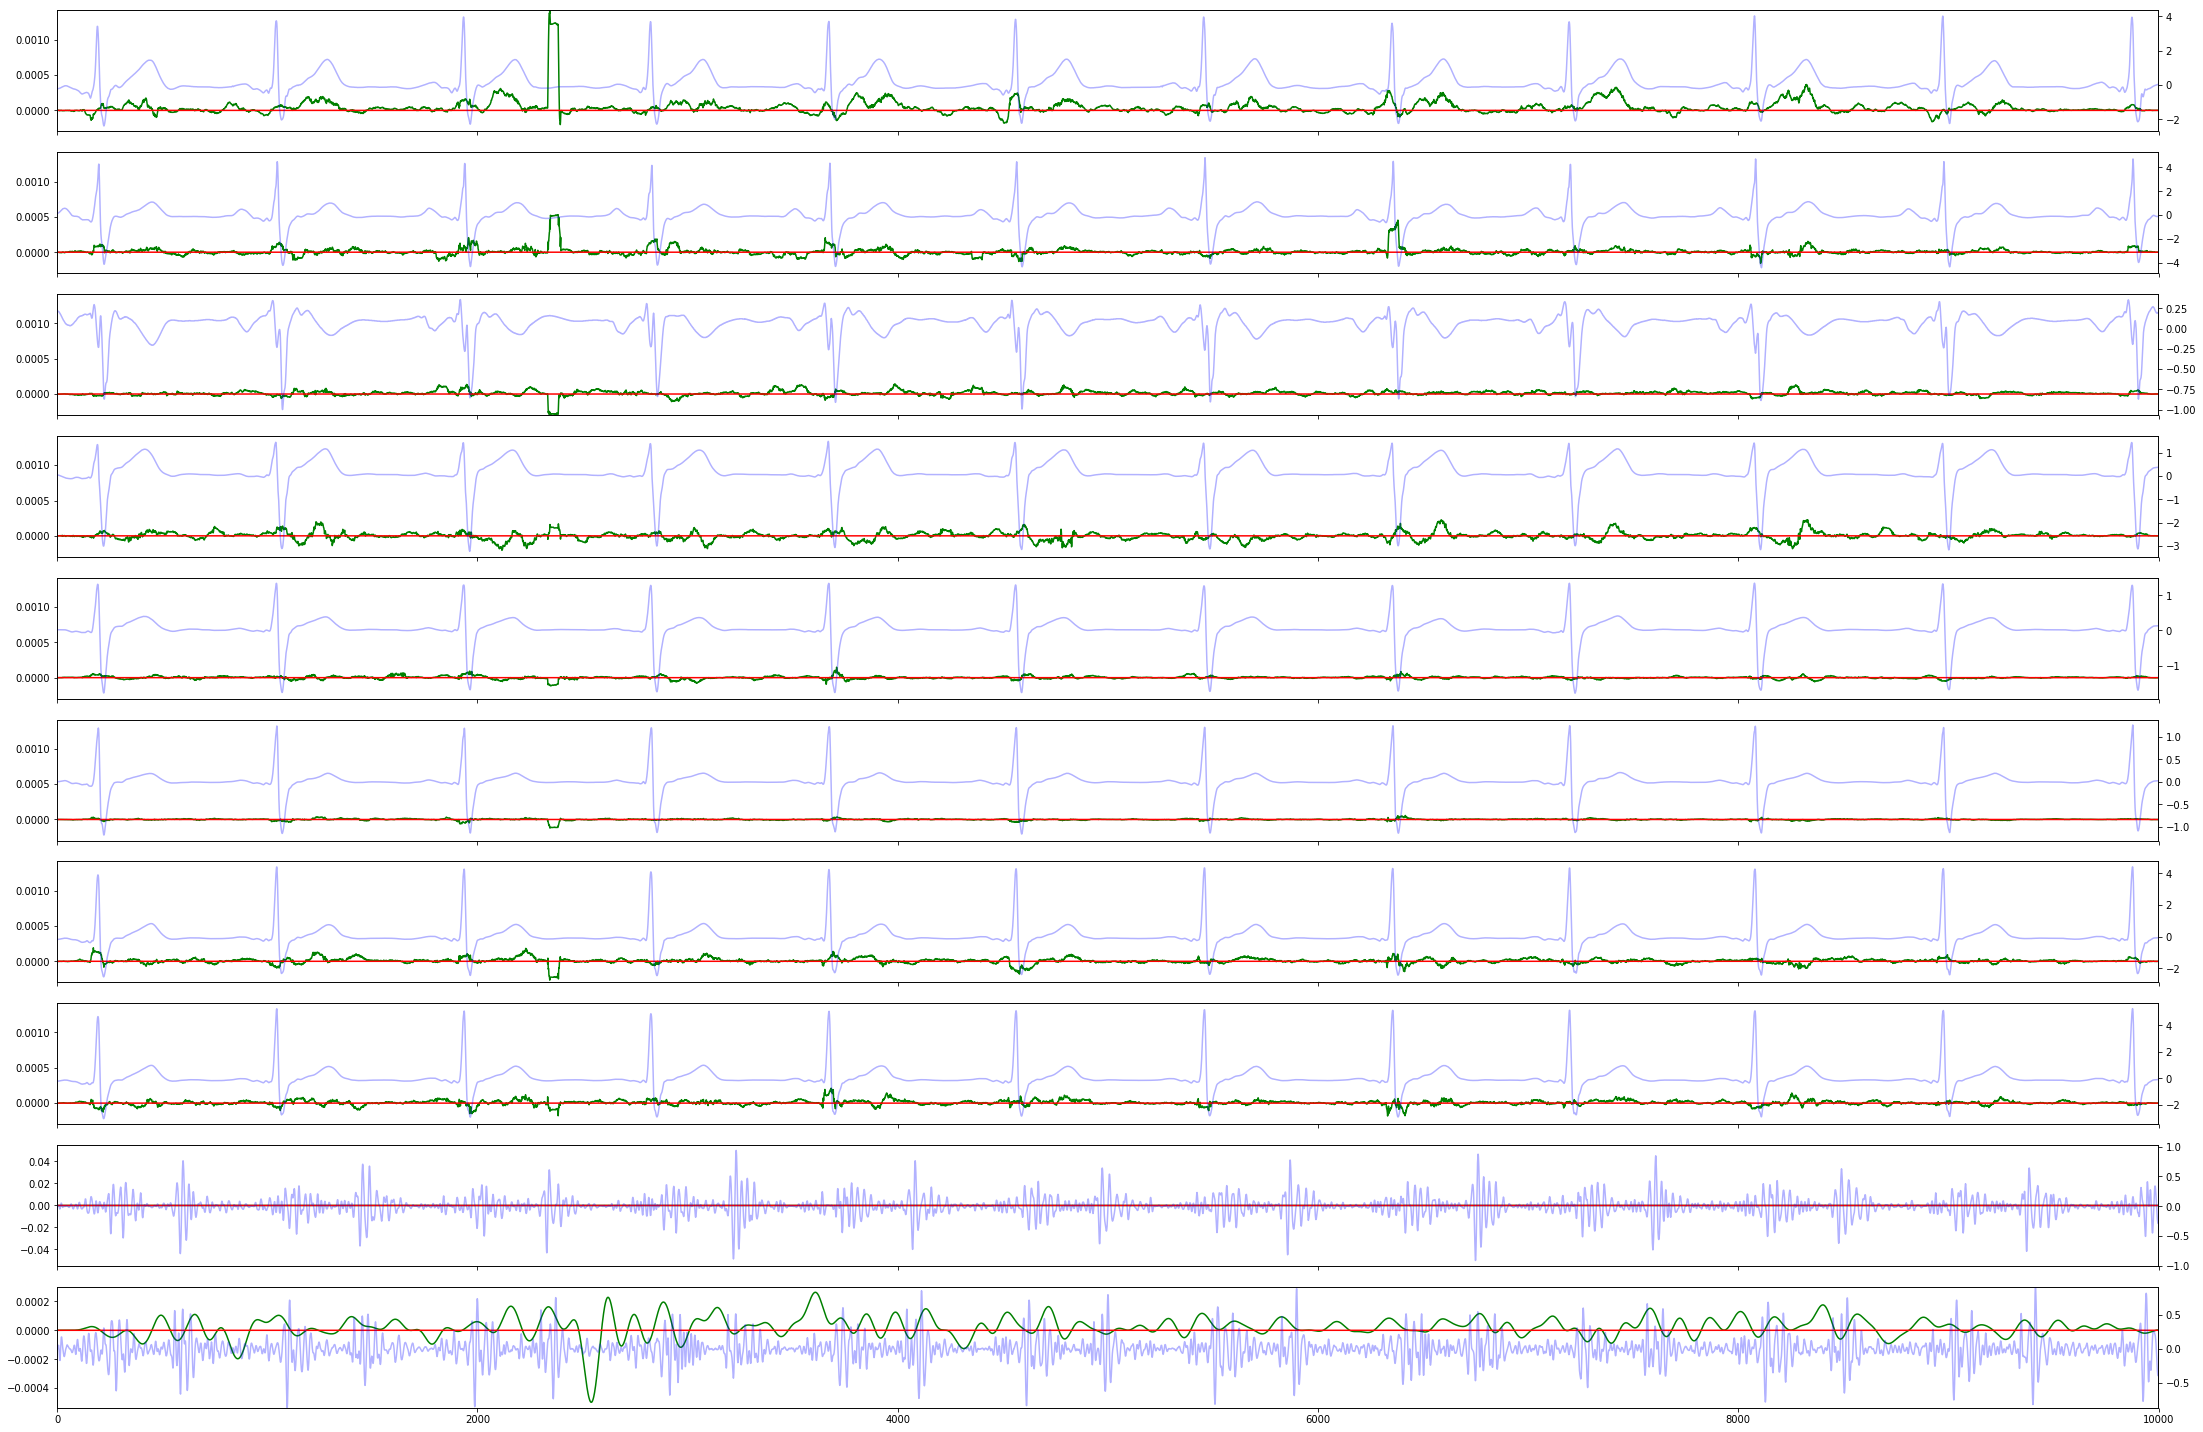


=============================== FAILED POSITIVE CASE ===============================

From Set: test set
Sample id: 120
Sample is abnormal
Predict abnormal chance: 0.046311285


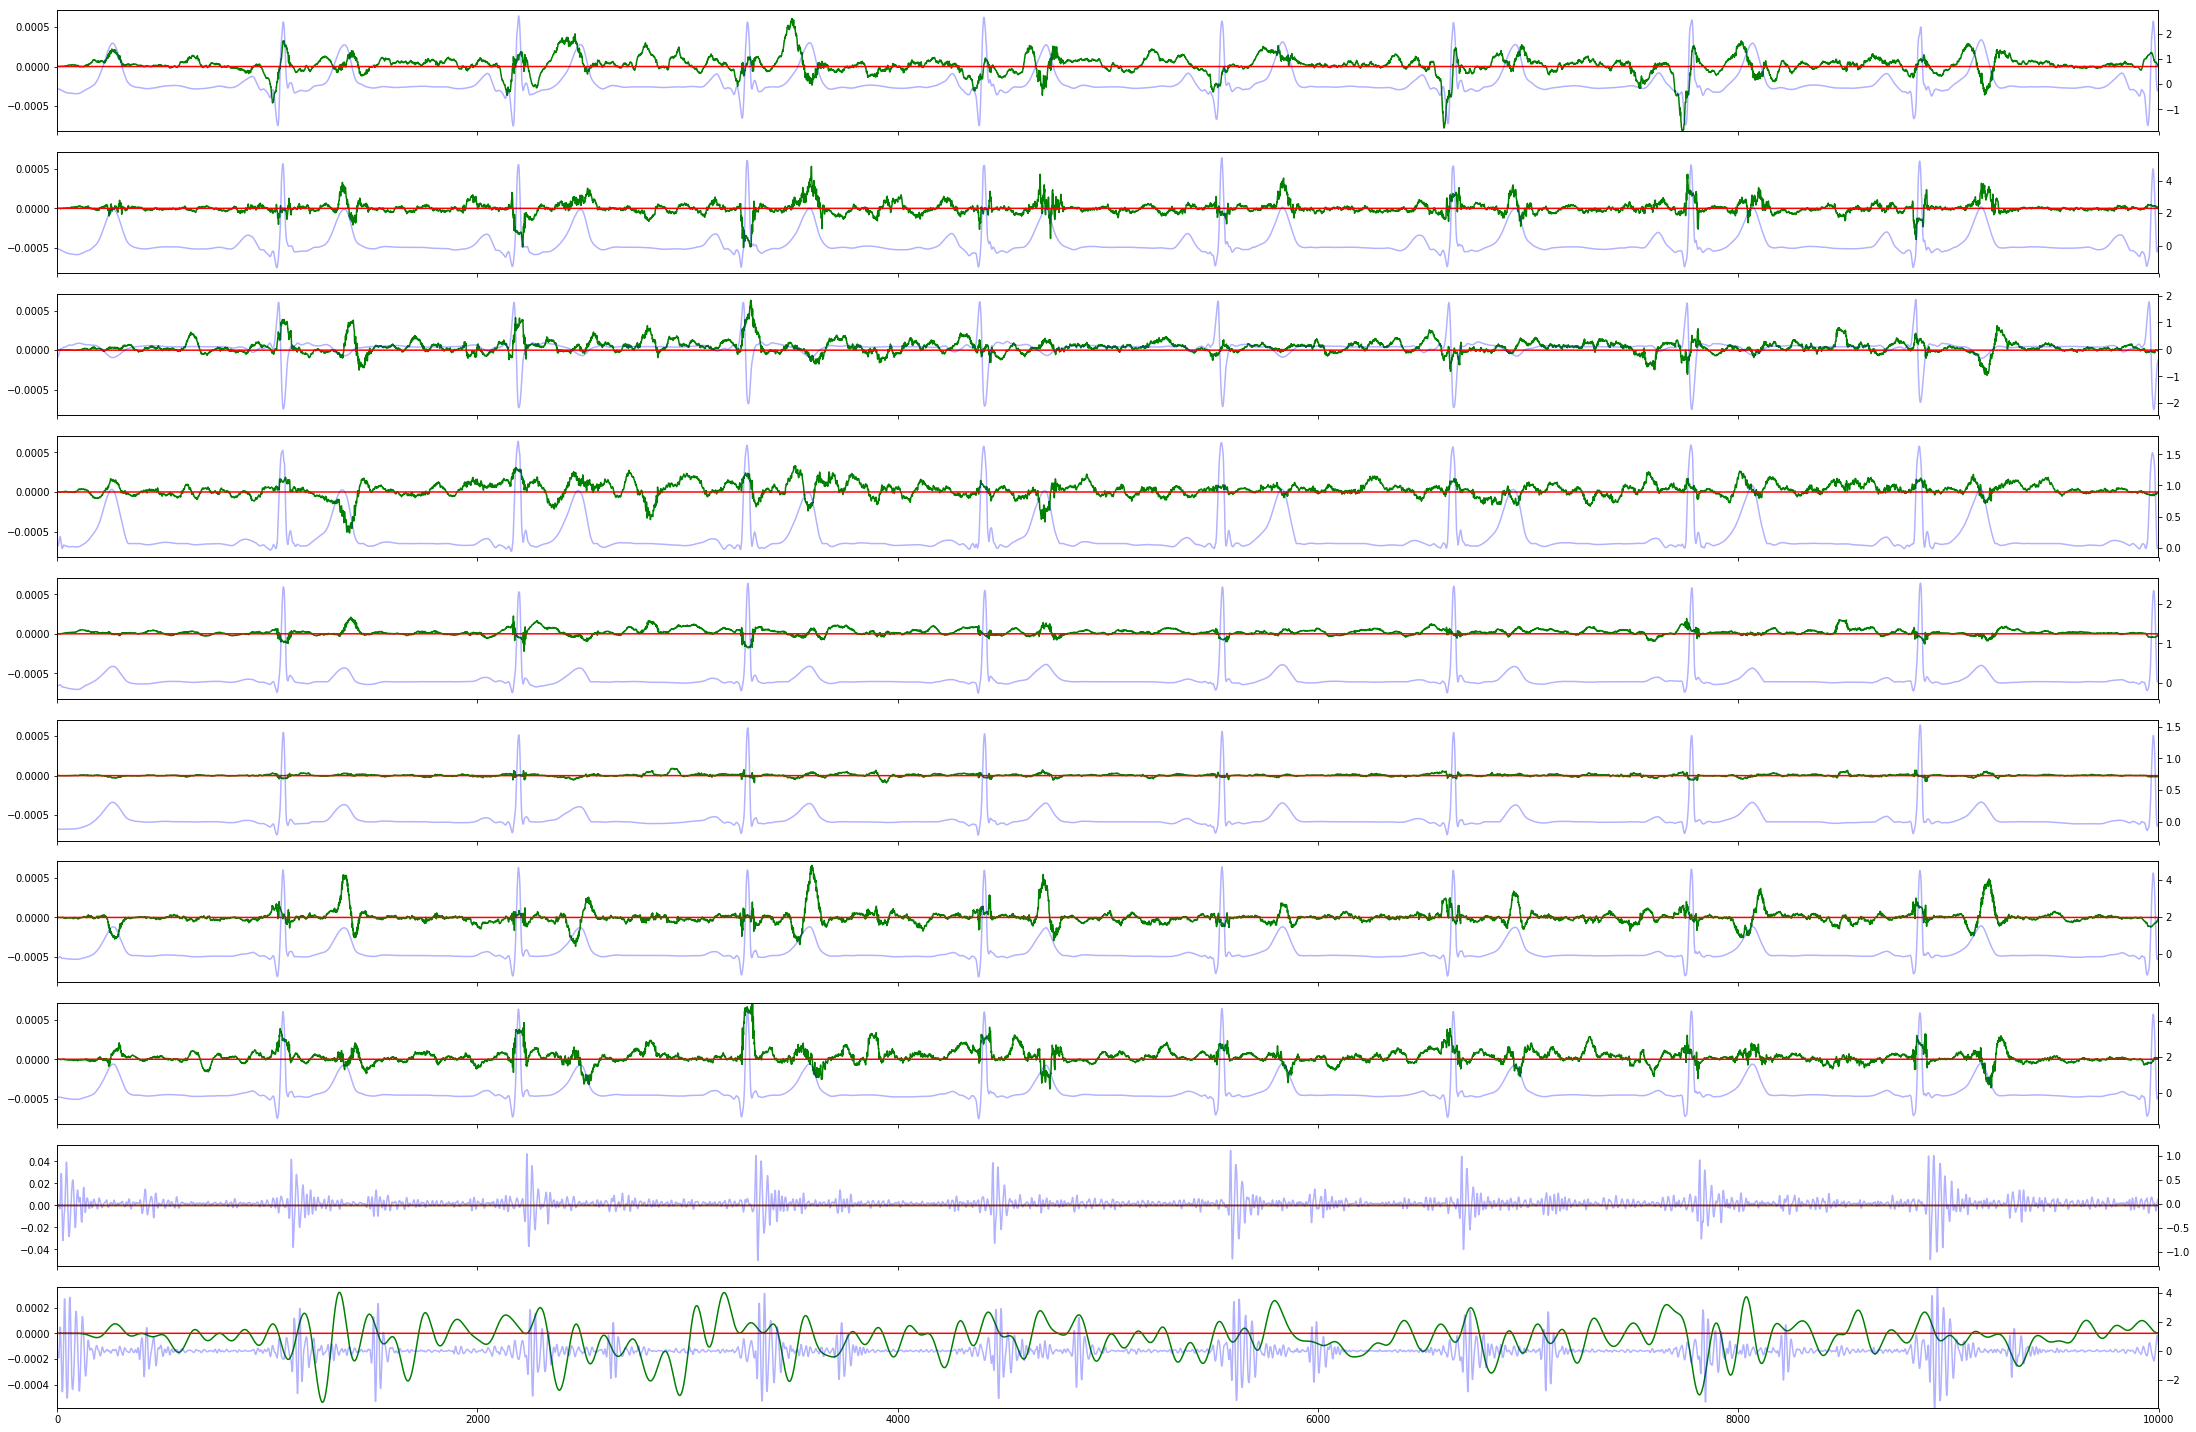


=============================== FAILED NEGATIVE CASE ===============================

From Set: test set
Sample id: 23
Sample is normal
Predict abnormal chance: 0.9889508


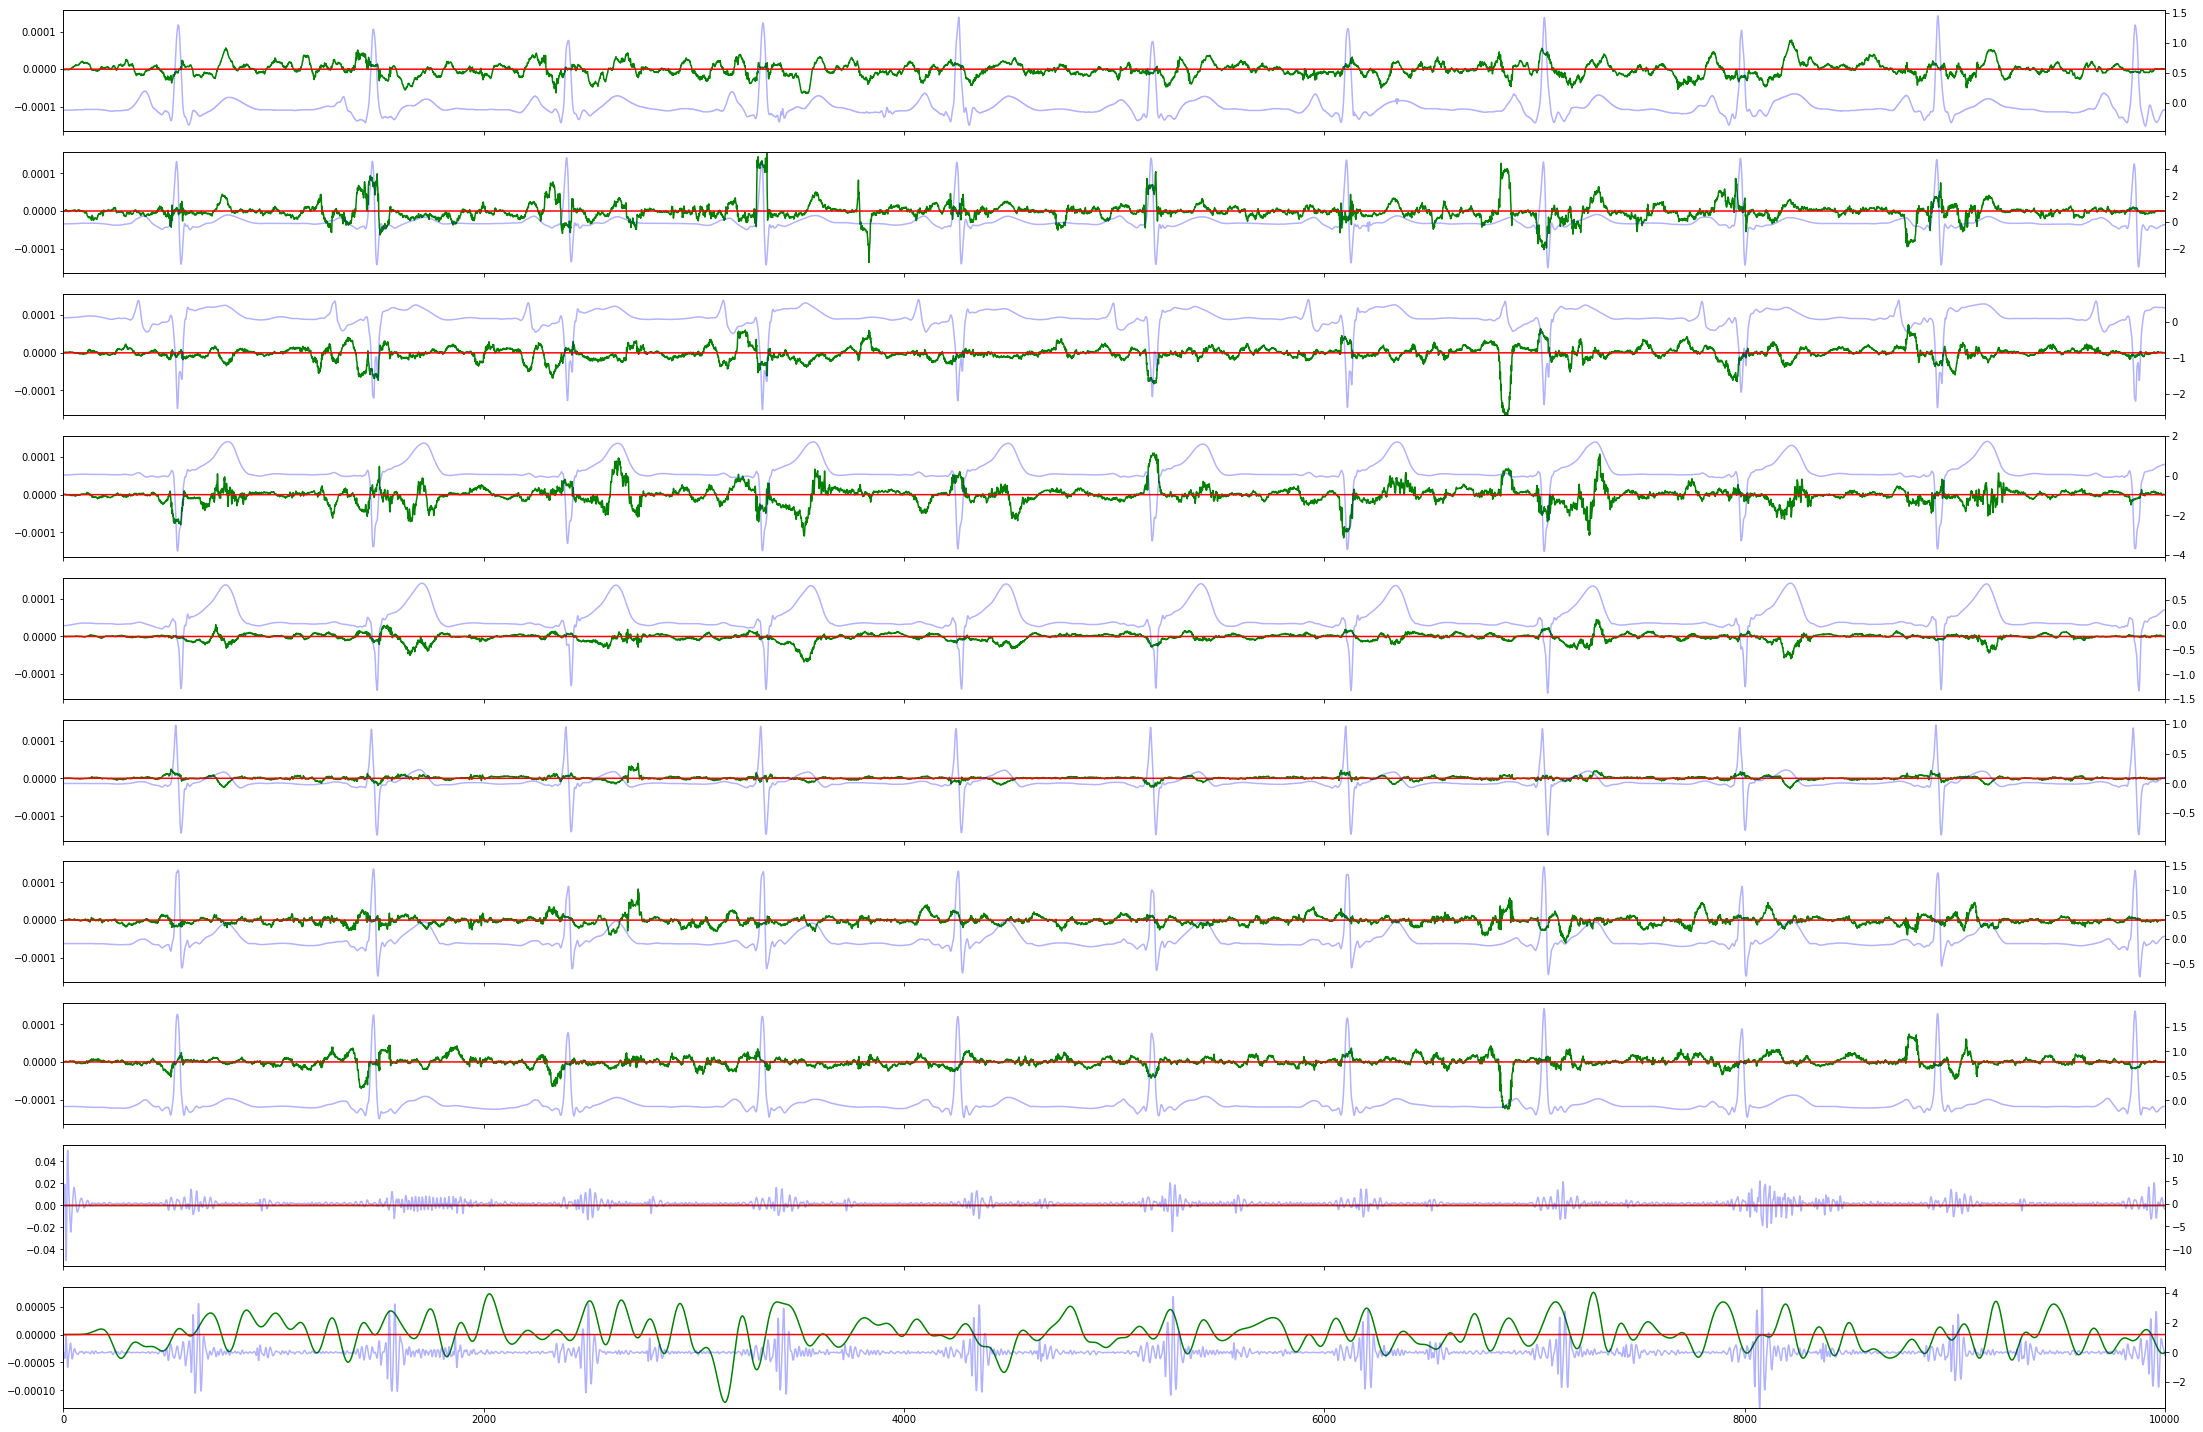

In [29]:
get_report('./model_checkpoints/workingV2_200_0.12/200-0.12.h5', 'test')

         when using: `python -m better_exceptions'. Otherwise, only code
         loaded from files will be inspected!


Loading model ./model_checkpoints/working_200_0.29/200-0.29.h5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10000, 10)    0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 10000, 2)     0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 10000, 1)     0           lambda_2[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 10000, 1)     0           lambda_2[0][0]                   
______________________________________________

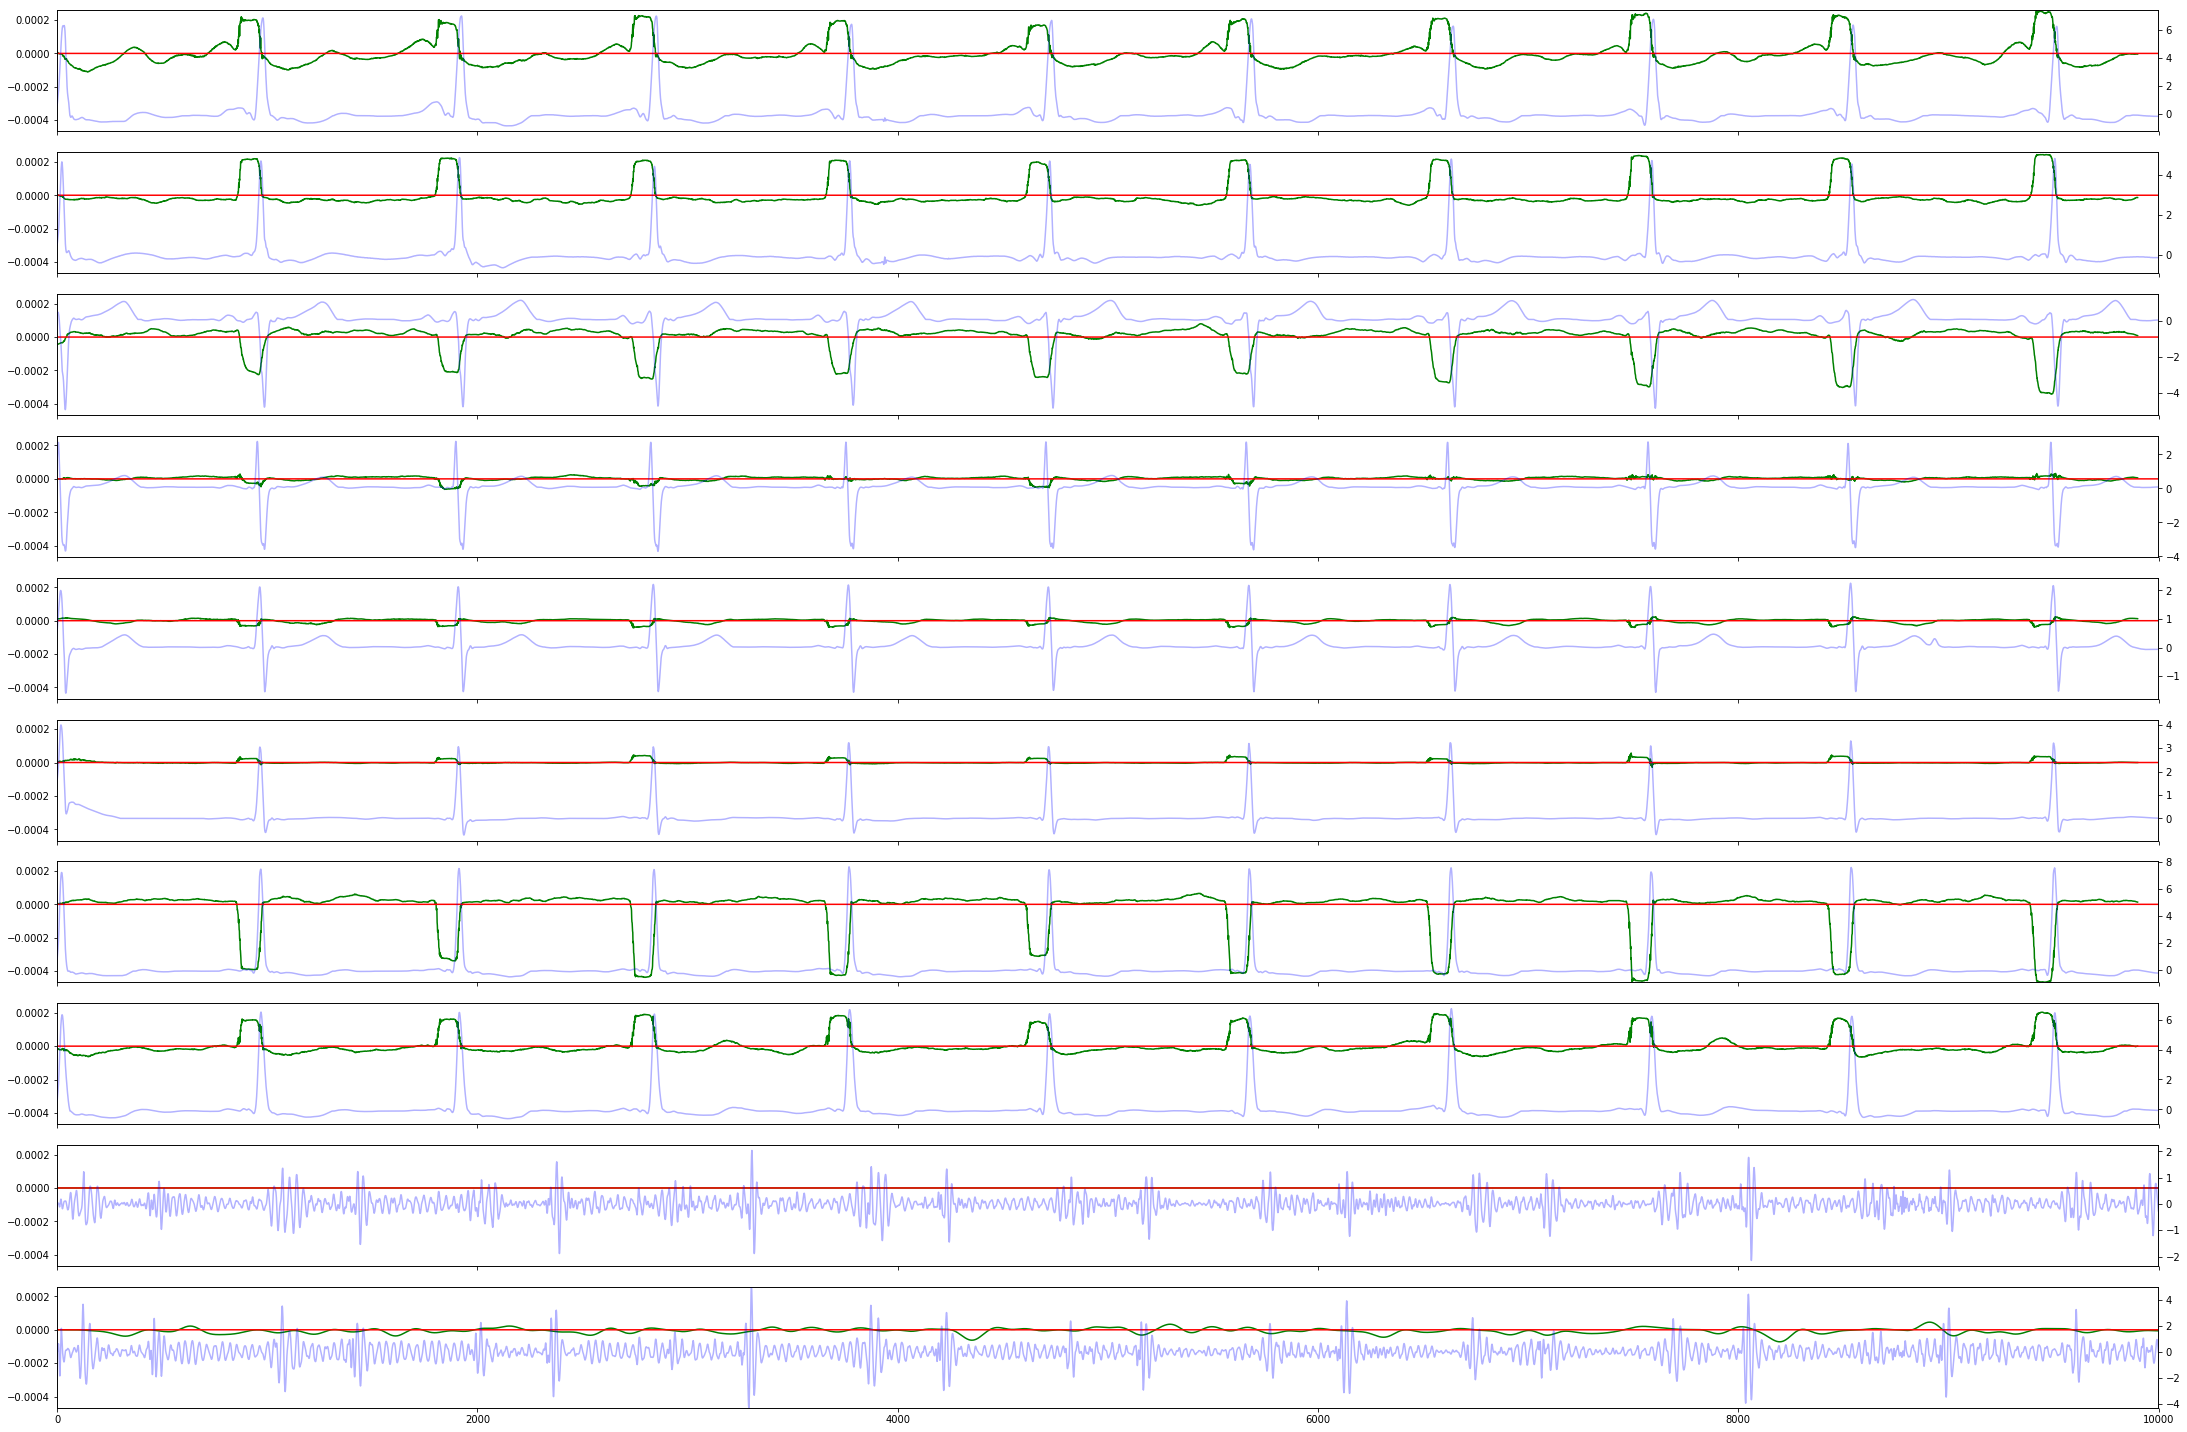


=============================== SUCCEED NEGATIVE CASE ===============================

From Set: test set
Sample id: 1
Sample is normal
Predict abnormal chance: 0.14996746


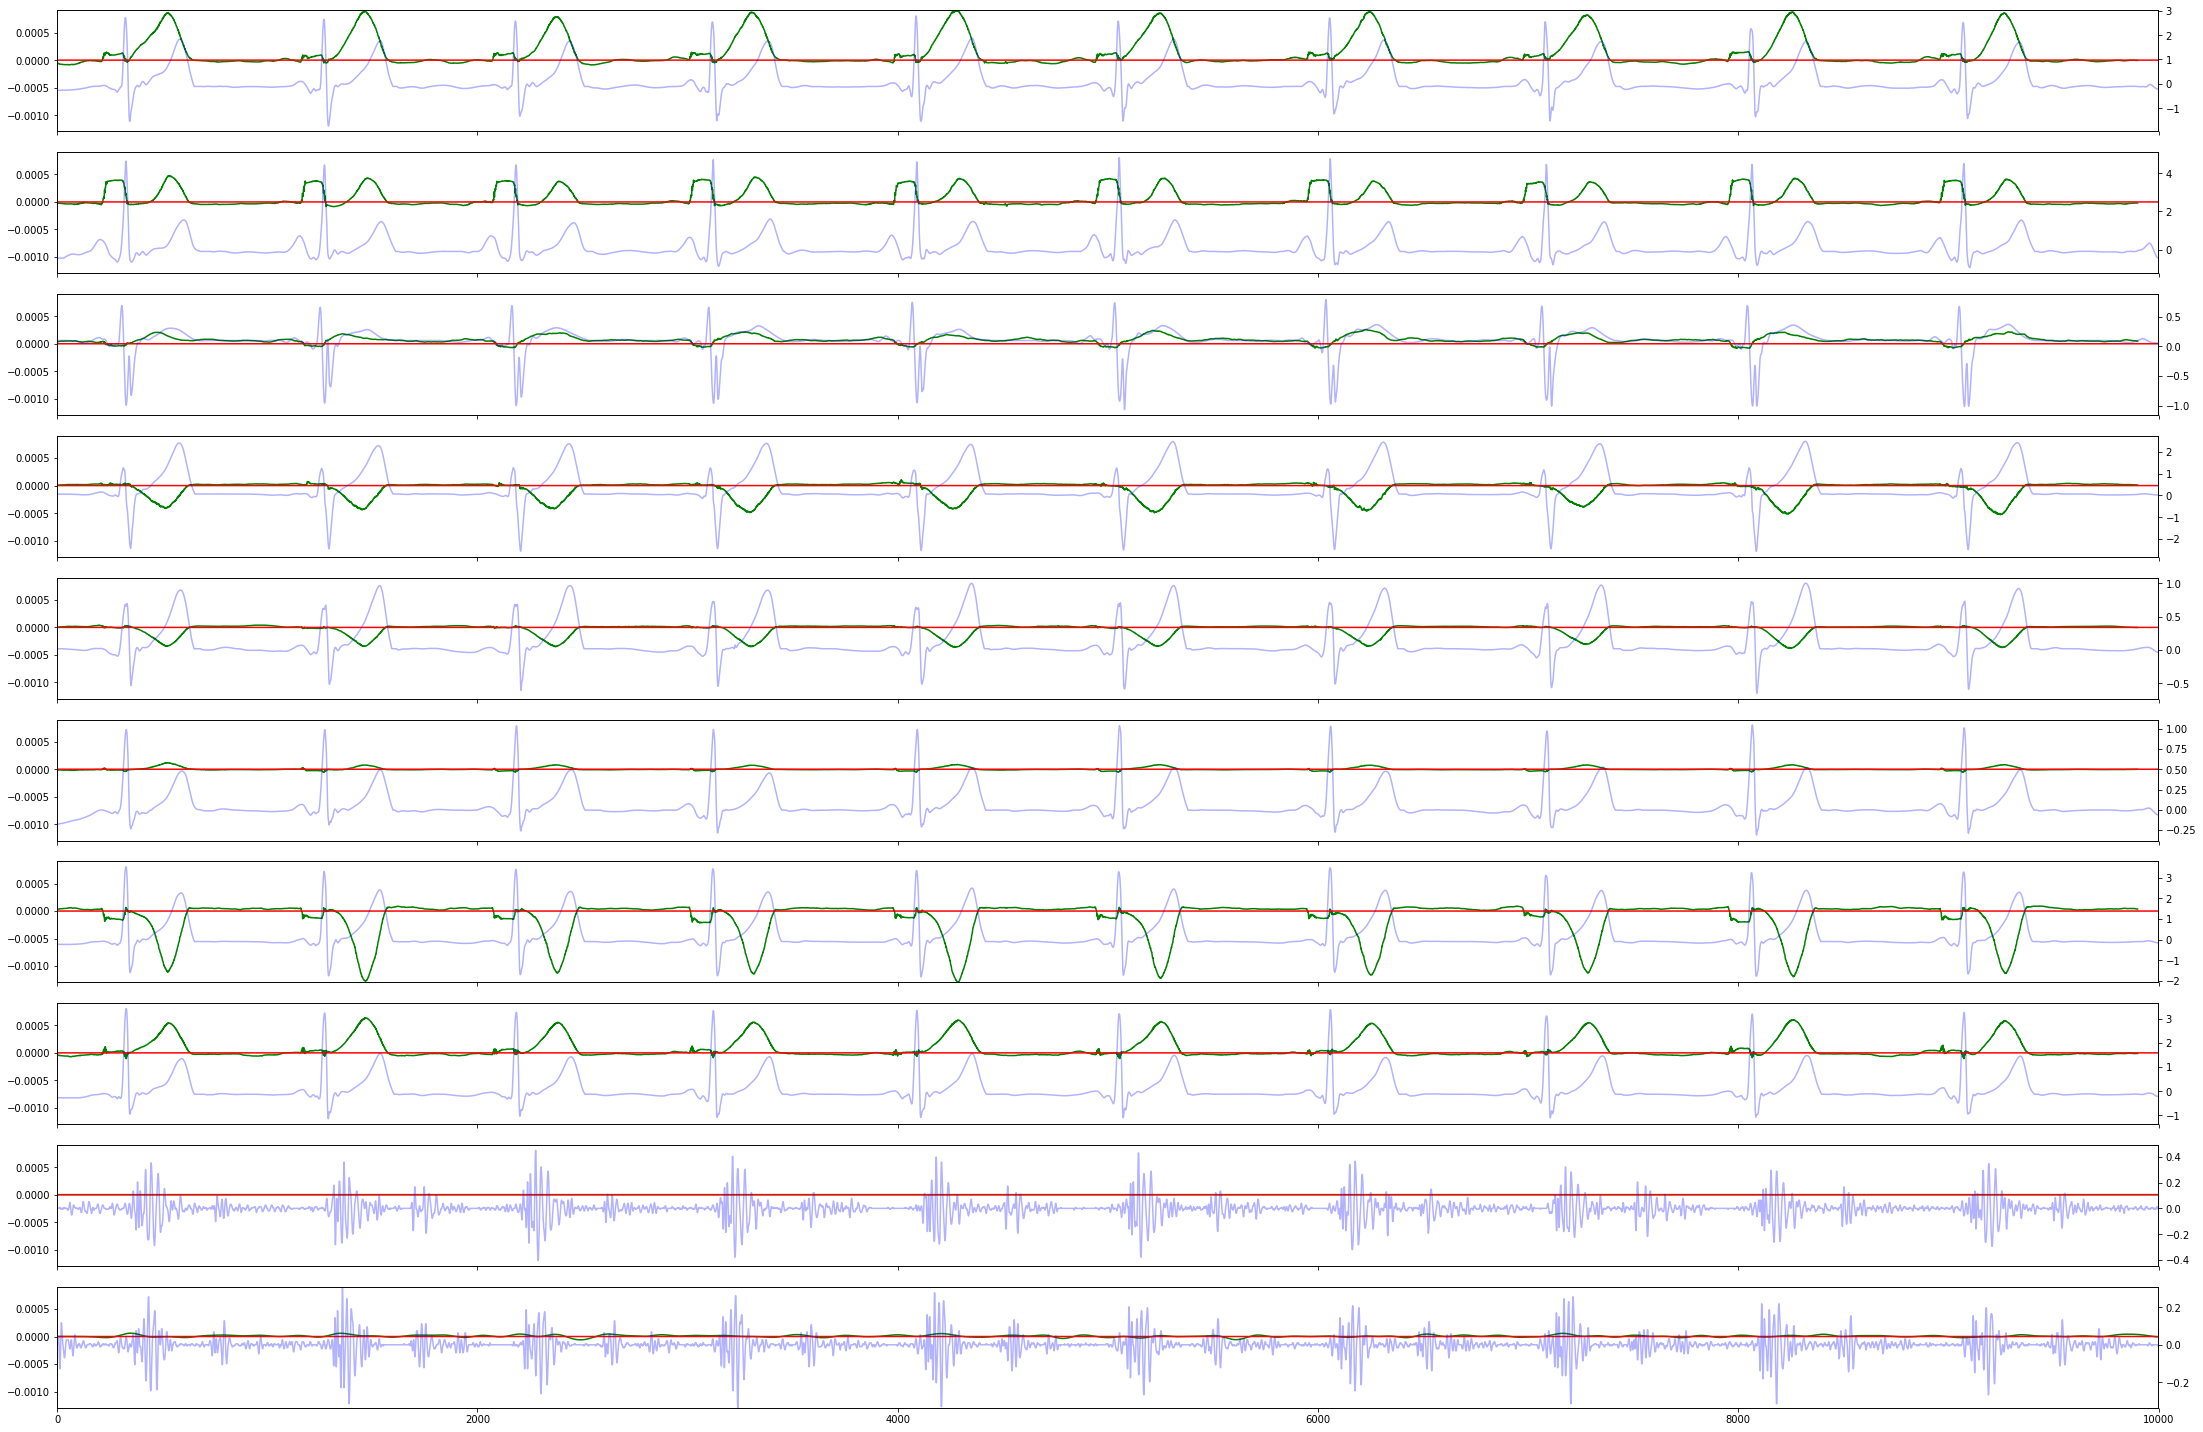


=============================== FAILED POSITIVE CASE ===============================

From Set: test set
Sample id: 116
Sample is abnormal
Predict abnormal chance: 0.012971888


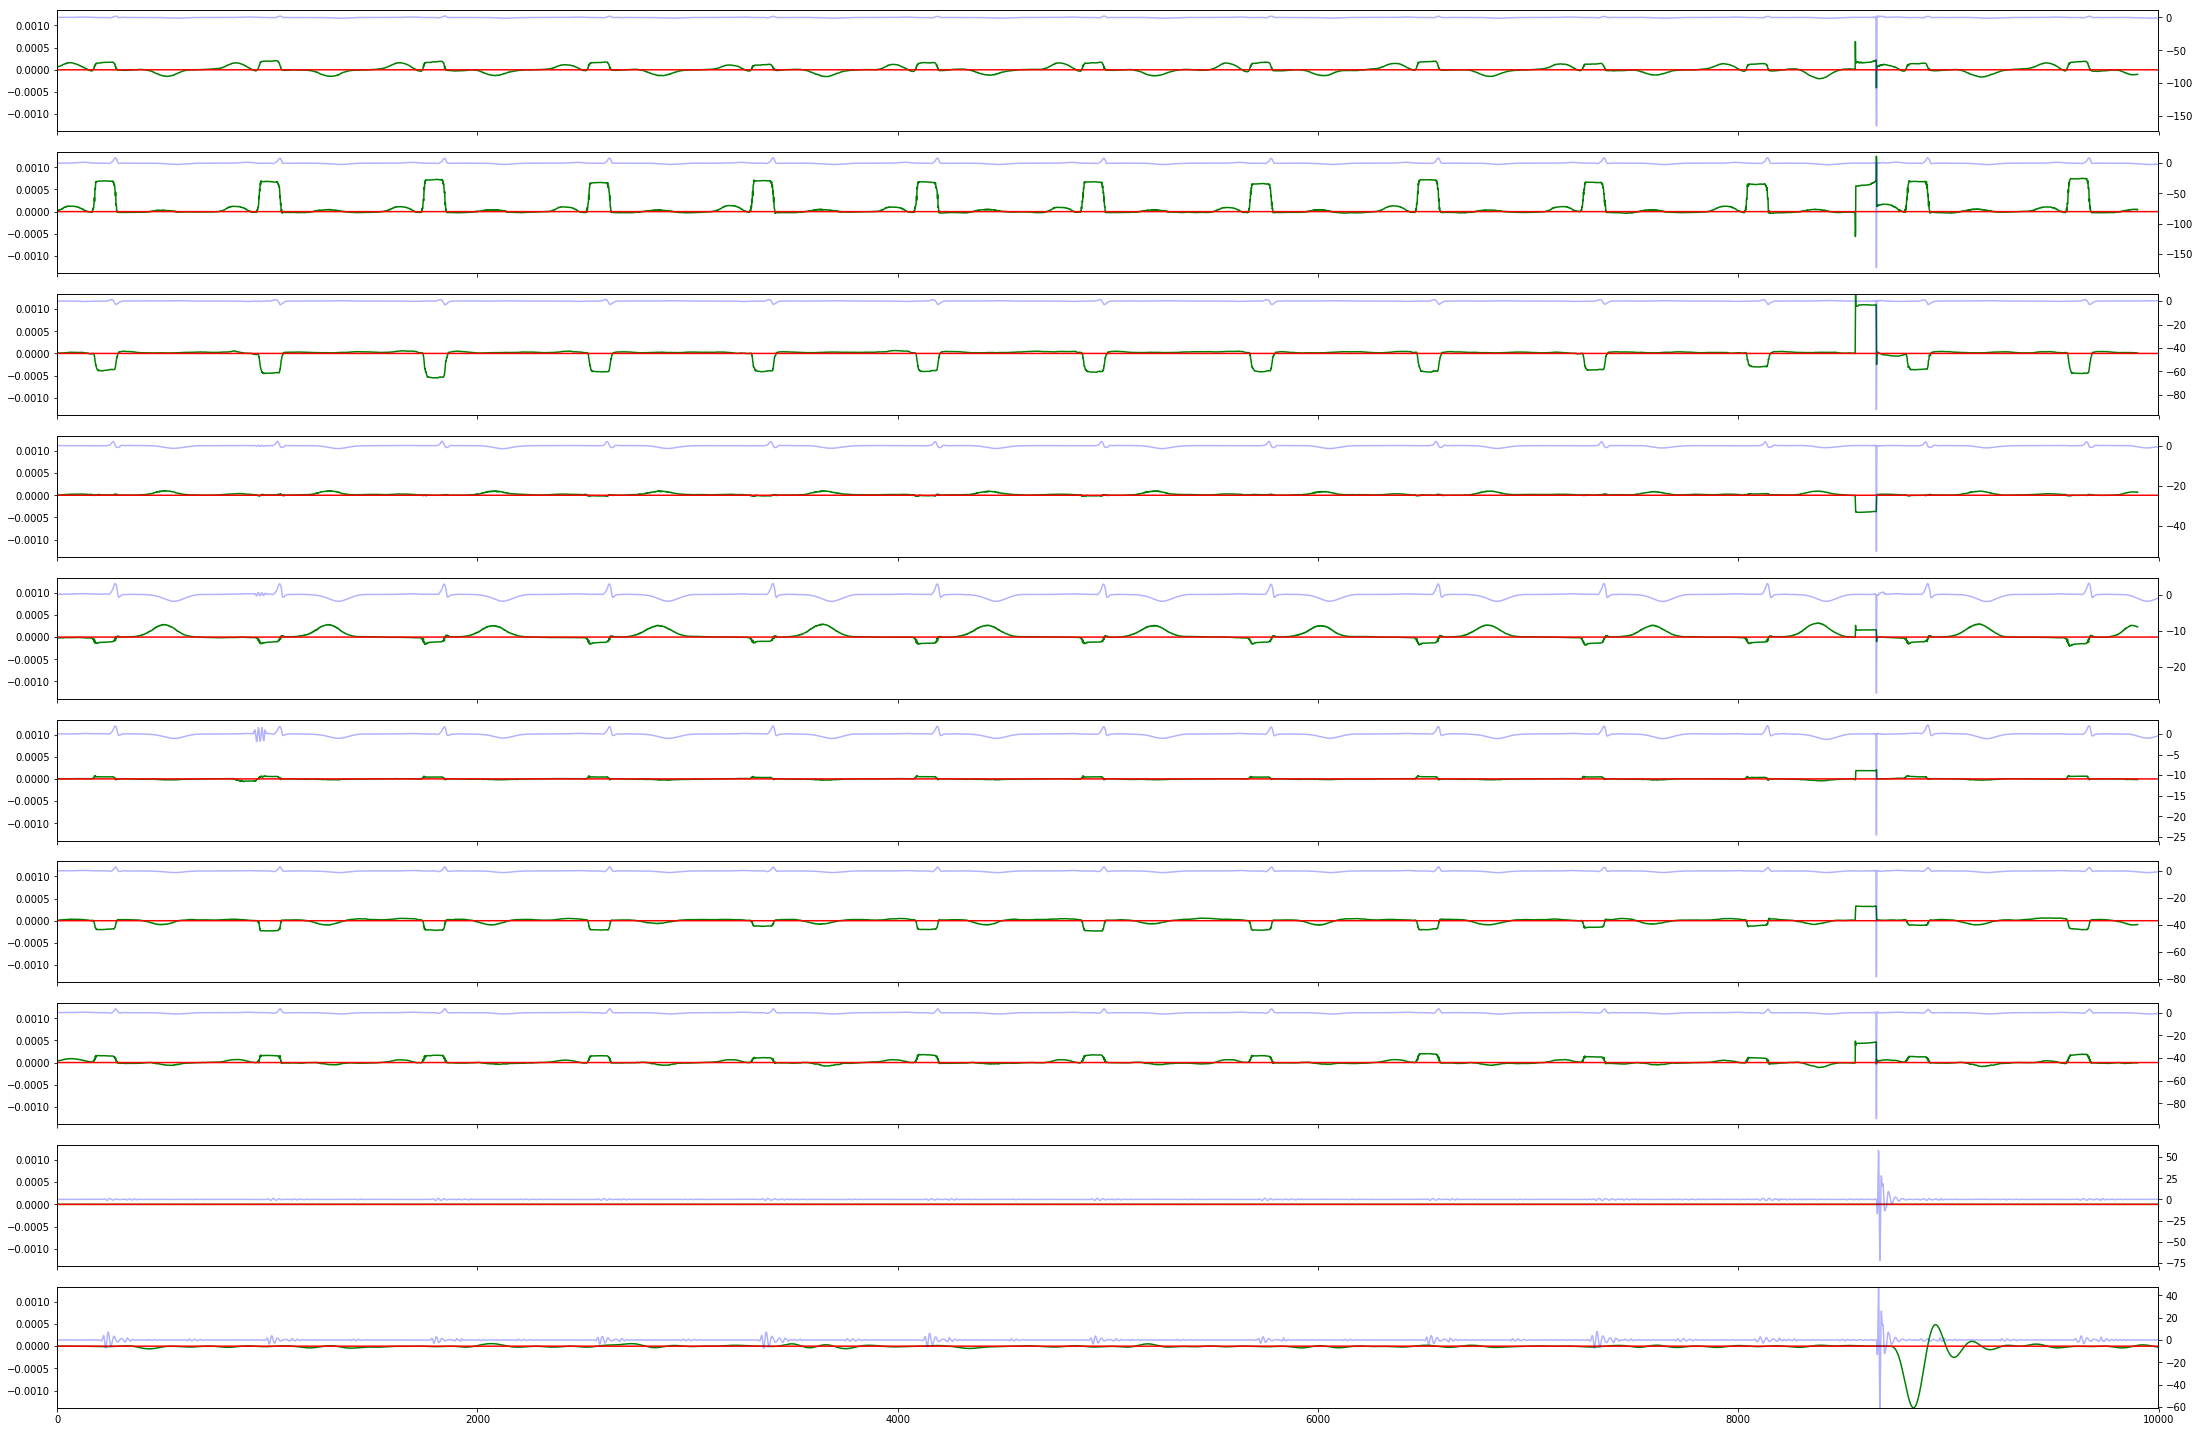


=============================== FAILED NEGATIVE CASE ===============================

From Set: test set
Sample id: 23
Sample is normal
Predict abnormal chance: 0.88402504


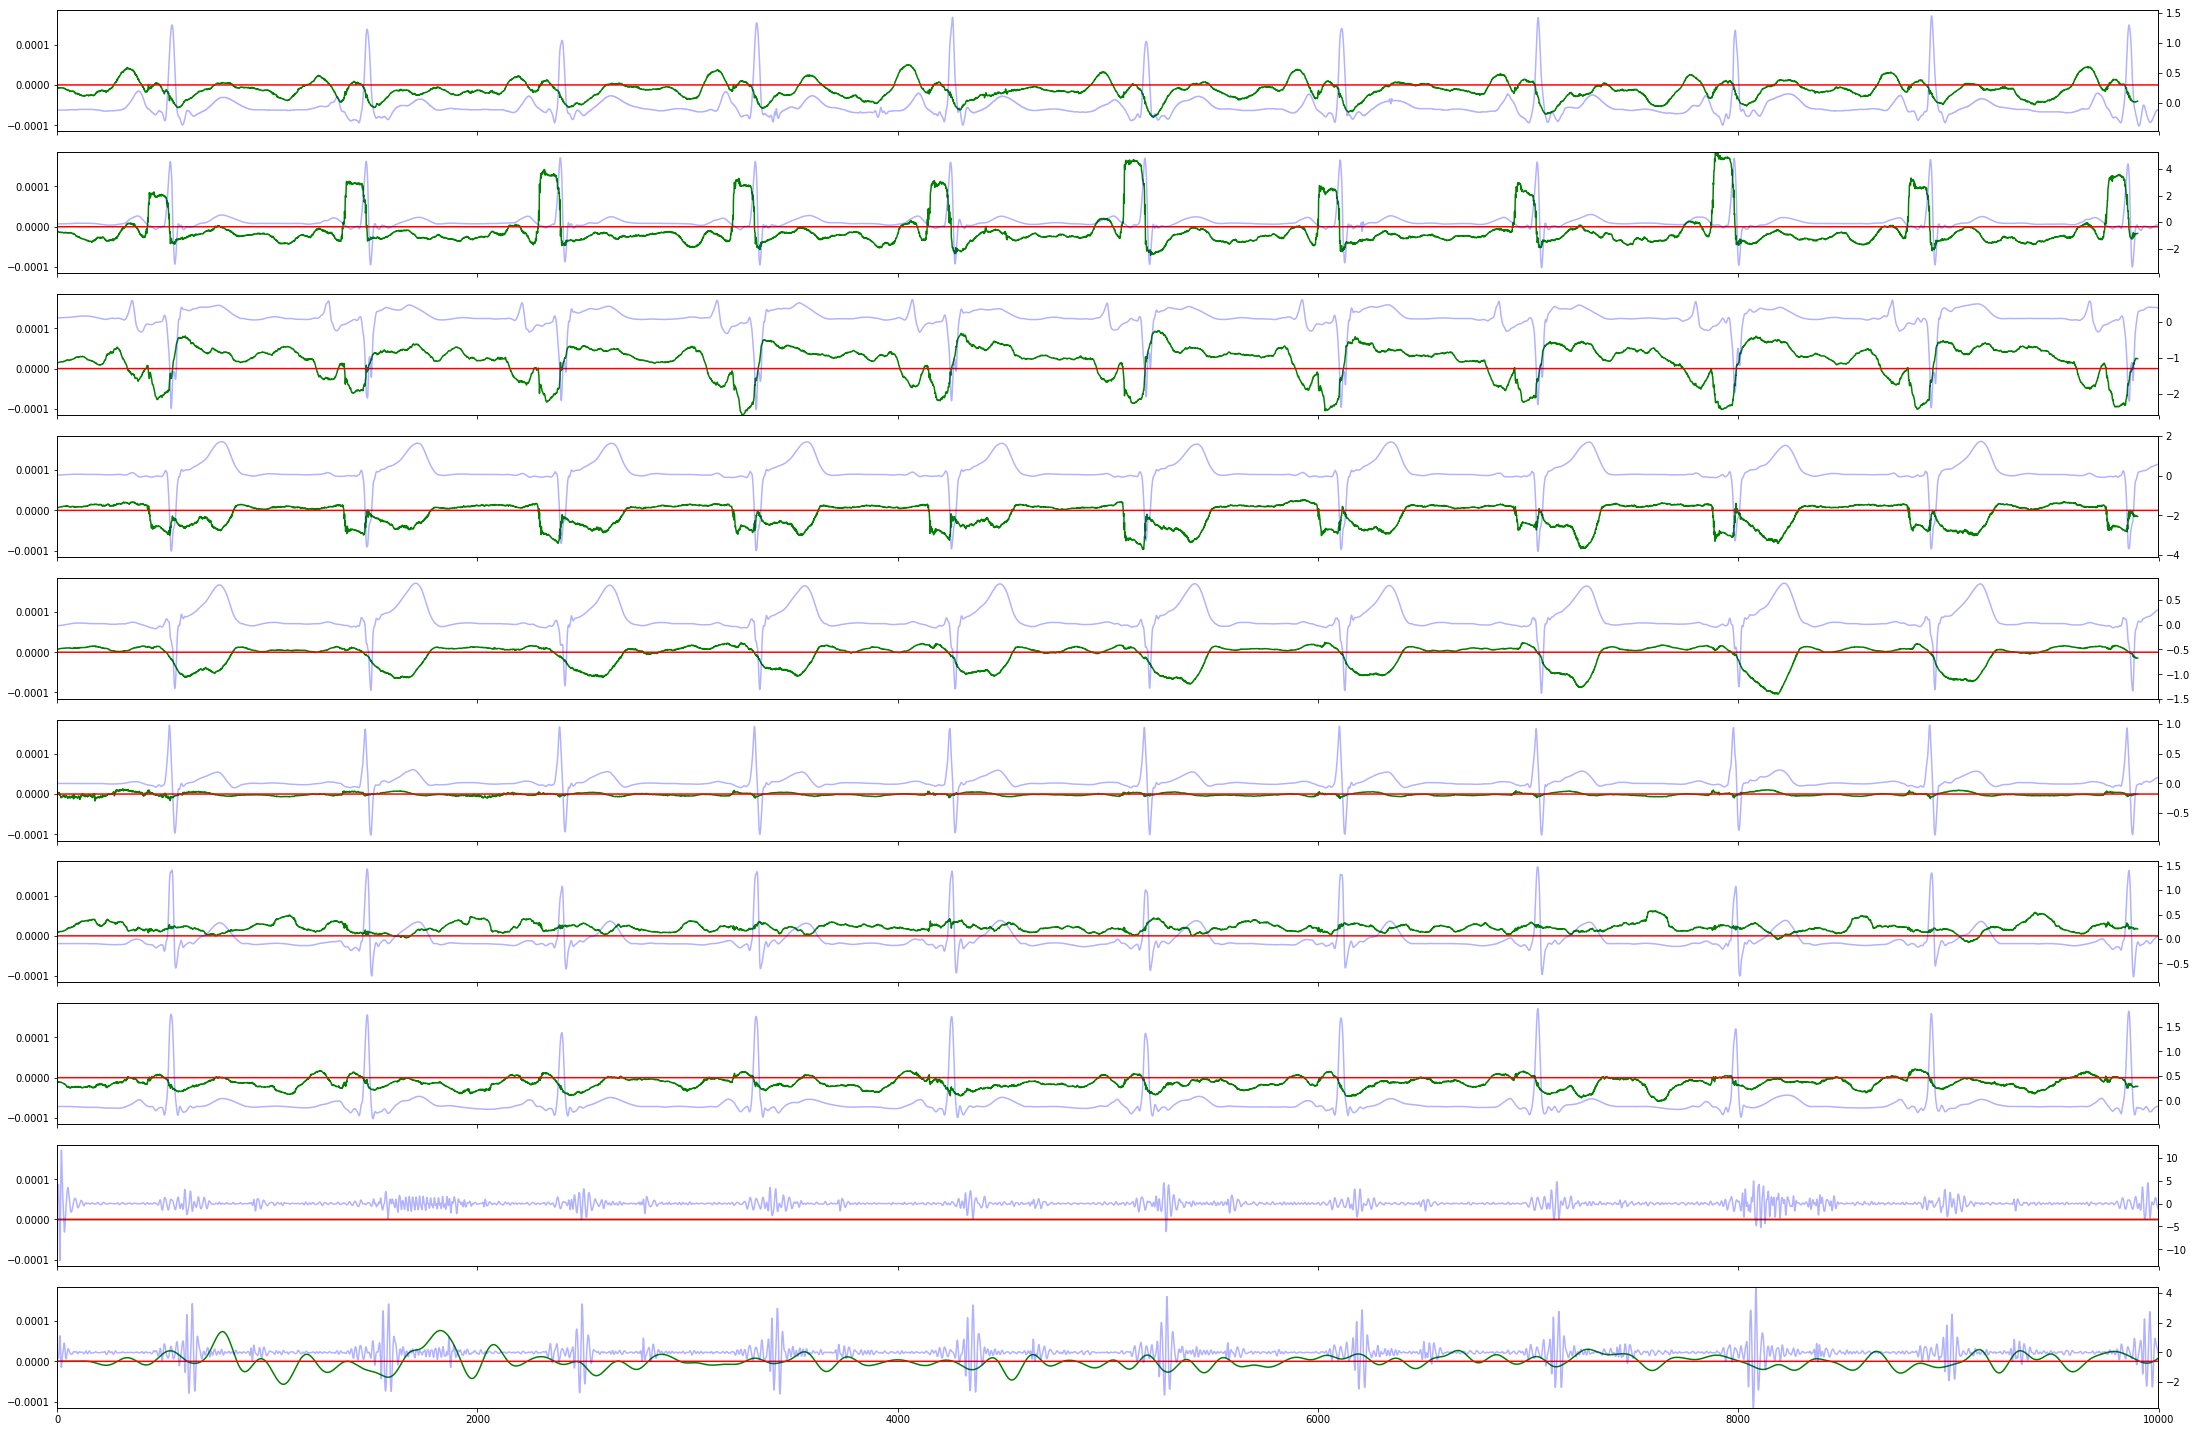

In [119]:
get_report('./model_checkpoints/working_200_0.29/200-0.29.h5', 'test')